# From NumPy arrays to Pandas DataFrame

This notebook is adapated from Joris Van den Bossche tutorial:

* https://github.com/paris-saclay-cds/python-workshop/blob/master/Day_1_Scientific_Python/02-pandas_introduction.ipynb

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = 8

# 0. Let's start with a showcase

#### Case 1: titanic survival data

In [3]:
df = pd.read_csv("datasets/titanic.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Starting from reading this dataset, to answering questions about this data in a few lines of code:

**What is the age distribution of the passengers?**

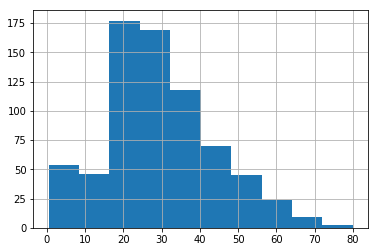

In [5]:
df['Age'].hist()

**How does the survival rate of the passengers differ between sexes?**

In [6]:
df.groupby('Sex')[['Survived']].aggregate(lambda x: x.sum() / len(x))

,Survived
Sex,
female,0.742038
male,0.188908


**Or how does it differ between the different classes?**

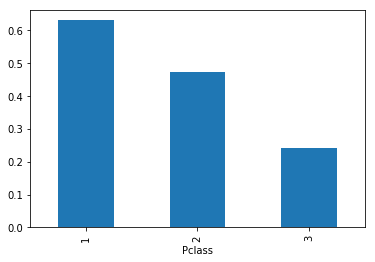

In [7]:
df.groupby('Pclass')['Survived'].aggregate(lambda x: x.sum() / len(x)).plot(kind='bar')

All the needed functionality for the above examples will be explained throughout this tutorial.

#### Case 2: air quality measurement timeseries

AirBase (The European Air quality dataBase): hourly measurements of all air quality monitoring stations from Europe

Starting from these hourly data for different stations:

In [10]:
data = pd.read_csv('datasets/20000101_20161231-NO2.csv', sep=';', skiprows=[1], na_values=['n/d'], index_col=0, parse_dates=True)

In [11]:
data.head()

,BASCH,BONAP,PA18,VERS
timestamp,,,,
2000-01-01 01:00:00,108.0,NaN,65.0,47.0
2000-01-01 02:00:00,104.0,60.0,77.0,42.0
2000-01-01 03:00:00,97.0,58.0,73.0,34.0
2000-01-01 04:00:00,77.0,52.0,57.0,29.0
2000-01-01 05:00:00,79.0,52.0,64.0,28.0


to answering questions about this data in a few lines of code:

**Does the air pollution show a decreasing trend over the years?**

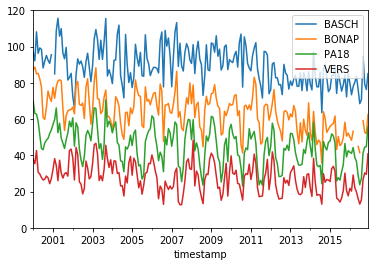

In [12]:
data['1999':].resample('M').mean().plot(ylim=[0,120])

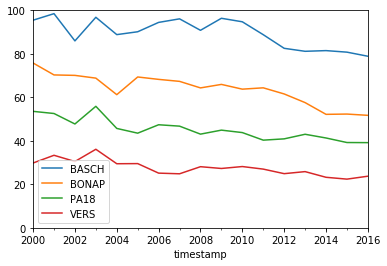

In [13]:
data['1999':].resample('A').mean().plot(ylim=[0,100])

**What is the difference in diurnal profile between weekdays and weekend?**

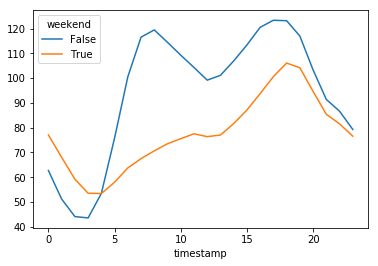

In [14]:
data['weekday'] = data.index.weekday
data['weekend'] = data['weekday'].isin([5, 6])
data_weekend = data.groupby(['weekend', data.index.hour])['BASCH'].mean().unstack(level=0)
data_weekend.plot()

We will come back to these example, and build them up step by step.

## 1. Pandas: data analysis in python

For data-intensive work in Python the [Pandas](http://pandas.pydata.org) library has become essential.

**What is `pandas`?**

* Pandas can be thought of as *NumPy arrays with labels* for rows and columns, and better support for heterogeneous data types, but it's also much, much more than that.
* Pandas can also be thought of as `R`'s `data.frame` in Python.
* Powerful for working with missing data, working with time series data, for reading and writing your data, for reshaping, grouping, merging your data, ...

It's documentation: http://pandas.pydata.org/pandas-docs/stable/


**When do you need pandas?**

When working with **tabular or structured data** (like R dataframe, SQL table, Excel spreadsheet, ...):

- Import data
- Clean up messy data
- Explore data, gain insight into data
- Process and prepare your data for analysis
- Analyse your data (together with scikit-learn, statsmodels, ...)

<div class="alert alert-warning">
<b>ATTENTION!</b>: <br><br>

Pandas is great for working with heterogeneous and tabular 1D/2D data, but not all types of data fit in such structures!
<ul>
<li>When working with array data (e.g. images, numerical algorithms): just stick with numpy</li>
<li>When working with multidimensional labeled data (e.g. climate data): have a look at [xarray](http://xarray.pydata.org/en/stable/)</li>
</ul>
</div>

## 2. The pandas data structures: `DataFrame` and `Series`

A `DataFrame` is a **tablular data structure** (multi-dimensional object to hold labeled data) comprised of rows and columns, akin to a spreadsheet, database table, or R's data.frame object. You can think of it as multiple Series object which share the same index.


<img align="left" width=50% src="./schema-dataframe.svg">

We can create a pandas Dataframe and specify the index and columns to use.

In [29]:
data = {'country': ['Belgium', 'France', 'Germany', 'Netherlands', 'United Kingdom'],
        'population': [11.3, 64.3, 81.3, 16.9, 64.9],
        'area': [30510, 671308, 357050, 41526, 244820],
        'capital': ['Brussels', 'Paris', 'Berlin', 'Amsterdam', 'London']}
df_countries = pd.DataFrame(data)
df_countries

,country,population,area,capital
0,Belgium,11.3,30510,Brussels
1,France,64.3,671308,Paris
2,Germany,81.3,357050,Berlin
3,Netherlands,16.9,41526,Amsterdam
4,United Kingdom,64.9,244820,London


As previously mentioned, the dataframe stores information regarding the column and index information.

In [ ]:
df_countries.columns

In [ ]:
df_countries.index

We previously saw that NumPy arrays store data using an homogeneous type and contiguously in memory. Pandas is used to store heterogeneous data where each column could be of different data types.

In [ ]:
df_countries.dtypes

You can get an overview of the information of a dataframe using the `info()` method:

In [ ]:
df_countries.info()

It is always possible to get a NumPy array, dropping the index and columns information:

In [ ]:
df_countries.values

However, be aware that all values will be upcasted in case of heterogeneous data.

### One-dimensional data: `Series` (a column of a DataFrame)

A Series is a basic holder for **one-dimensional labeled data**.

In [ ]:
df_countries['population']

In [ ]:
population = df_countries['population']

A pandas series as an index as well. Like the dataframe, you can get a NumPy array calling the attribute `values`

In [ ]:
population.values

### Exercise

We will define a set of 1D NumPy arrays containing the data that we will work with.

In [18]:
country_name = np.array(['Austria', 'Iran, Islamic Rep.', 'France'], dtype=object)
country_code = np.array(['AUT', 'IRN', 'FRA'], dtype=object)
gdp_2015 = np.array([1349034029453.37, 385874474398.59, 2438207896251.84])
gdp_2017 = np.array([1532397555.55556, 439513511620.591,2582501307216.42])

* Create a `DataFrame` by passing a single NumPy array (Hint: concatenate the differen 1D NumPy arrays). In addition, provide a Python list with the name of the columns to the `columns` parameter.

In [20]:
# %load solutions/01_solutions.py
data = np.vstack((country_name, country_code, gdp_2015, gdp_2017)).T
df = pd.DataFrame(data, columns=['Country Name', 'Country Code', 2015, 2017])
df


,Country Name,Country Code,2015,2017
0,Austria,AUT,1.34903e+12,1.5324e+09
1,"Iran, Islamic Rep.",IRN,3.85874e+11,4.39514e+11
2,France,FRA,2.43821e+12,2.5825e+12


* Instead of concatenating the data, create a Python dictionary where the keys will be the name of the columns and the values will be the corresponding NumPy array.

In [22]:
# %load solutions/02_solutions.py
df = pd.DataFrame({'Country Name': country_name,
                   'Country Code': country_code,
                   2015: gdp_2015,
                   2017: gdp_2017})
df


,Country Name,Country Code,2015,2017
0,Austria,AUT,1.349034e+12,1.532398e+09
1,"Iran, Islamic Rep.",IRN,3.858745e+11,4.395135e+11
2,France,FRA,2.438208e+12,2.582501e+12


* Use the same procedure (Python dictionary) but specify that the country code should be used as the index.

In [25]:
# %load solutions/03_solutions.py
df = pd.DataFrame({'Country Name': country_name,
                   'Country Code': country_code,
                   2015: gdp_2015,
                   2017: gdp_2017})
df = df.set_index('Country Code')
df


,Country Name,2015,2017
Country Code,,,
AUT,Austria,1.349034e+12,1.532398e+09
IRN,"Iran, Islamic Rep.",3.858745e+11,4.395135e+11
FRA,France,2.438208e+12,2.582501e+12


In [27]:
# %load solutions/04_solutions.py
df = pd.DataFrame({'Country Name': country_name,
                   2015: gdp_2015,
                   2017: gdp_2017},
                  index=country_code)
df


,Country Name,2015,2017
AUT,Austria,1.349034e+12,1.532398e+09
IRN,"Iran, Islamic Rep.",3.858745e+11,4.395135e+11
FRA,France,2.438208e+12,2.582501e+12


## 3. Selecting and filtering data

<div class="alert alert-warning">
<b>ATTENTION!</b>: <br><br>

One of pandas' basic features is the labeling of rows and columns, but this makes indexing also a bit more complex compared to numpy. <br><br> We now have to distuinguish between:

 <ul>
  <li>selection by **label**</li>
  <li>selection by **position**</li>
</ul>
</div>

For this example, we will reuse the `df_countries` dataset.

In [30]:
df_countries

,country,population,area,capital
0,Belgium,11.3,30510,Brussels
1,France,64.3,671308,Paris
2,Germany,81.3,357050,Berlin
3,Netherlands,16.9,41526,Amsterdam
4,United Kingdom,64.9,244820,London


### `df[]` provides some convenience shortcuts 

For a DataFrame, basic indexing selects the columns.

Selecting a single column:

In [31]:
df_countries['population']

0    11.3
1    64.3
2    81.3
3    16.9
4    64.9
Name: population, dtype: float64

or multiple columns:

In [32]:
df_countries[['country', 'capital']]

,country,capital
0,Belgium,Brussels
1,France,Paris
2,Germany,Berlin
3,Netherlands,Amsterdam
4,United Kingdom,London


But, slicing accesses the rows:

In [33]:
df_countries[2:5]

,country,population,area,capital
2,Germany,81.3,357050,Berlin
3,Netherlands,16.9,41526,Amsterdam
4,United Kingdom,64.9,244820,London


### Systematic indexing with `loc` and `iloc`

When using `[]` like above, you can only select from one axis at once (rows or columns, not both). For more advanced indexing, you have some extra attributes:
    
* `loc`: selection by label
* `iloc`: selection by position

In [34]:
df_countries = df_countries.set_index('country')

In [35]:
df_countries

,population,area,capital
country,,,
Belgium,11.3,30510,Brussels
France,64.3,671308,Paris
Germany,81.3,357050,Berlin
Netherlands,16.9,41526,Amsterdam
United Kingdom,64.9,244820,London


In [36]:
df_countries.loc['France', 'capital']

'Paris'

In [37]:
df_countries.loc['France':'Netherlands', :]

,population,area,capital
country,,,
France,64.3,671308,Paris
Germany,81.3,357050,Berlin
Netherlands,16.9,41526,Amsterdam


Selecting by position with `iloc` works similar as indexing numpy arrays:

In [38]:
df_countries.iloc[0:2,1:3]

,area,capital
country,,
Belgium,30510,Brussels
France,671308,Paris


The different indexing methods can also be used to assign data:

In [39]:
df_countries.loc['France', 'population'] = 70

In [40]:
df_countries

,population,area,capital
country,,,
Belgium,11.3,30510,Brussels
France,70.0,671308,Paris
Germany,81.3,357050,Berlin
Netherlands,16.9,41526,Amsterdam
United Kingdom,64.9,244820,London


### Boolean indexing (filtering)

Often, you want to select rows based on a certain condition. This can be done with 'boolean indexing' (like a where clause in SQL) and comparable to numpy. 

The indexer (or boolean mask) should be 1-dimensional and the same length as the thing being indexed.

In [41]:
df_countries['population'] > 60

country
Belgium           False
France             True
Germany            True
Netherlands       False
United Kingdom     True
Name: population, dtype: bool

In [42]:
df_countries[df_countries['population'] > 60]

,population,area,capital
country,,,
France,70.0,671308,Paris
Germany,81.3,357050,Berlin
United Kingdom,64.9,244820,London


### Exercise

In [44]:
df = pd.read_csv("datasets/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Select the sub-dataframe for which the men are older than 60 years old. Using the attribute shape, find how many individual correspond to this criteria.

In [ ]:
# %load solutions/05_solutions.py
df[(df['Sex'] == 'male') & (df['Age'] > 60)].shape[0]


## 4. Statistical analysis

Pandas provides an easy and fast way to explore data. Let's explore the `titanic` data set.

In [47]:
df = df.set_index('Name')
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Name,,,,,,,,,,,
"Braund, Mr. Owen Harris",1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
"Heikkinen, Miss. Laina",3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1,1,female,35.0,1,0,113803,53.1000,C123,S
"Allen, Mr. William Henry",5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


We will select the `Age` column and compute couple of statistic.

In [48]:
age = df['Age']
age

Name
Braund, Mr. Owen Harris                                22.0
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    38.0
Heikkinen, Miss. Laina                                 26.0
Futrelle, Mrs. Jacques Heath (Lily May Peel)           35.0
                                                       ... 
Graham, Miss. Margaret Edith                           19.0
Johnston, Miss. Catherine Helen "Carrie"                NaN
Behr, Mr. Karl Howell                                  26.0
Dooley, Mr. Patrick                                    32.0
Name: Age, Length: 891, dtype: float64

In [49]:
age.mean()

29.69911764705882

In [50]:
age.max()

80.0

In [51]:
age.min()

0.42

In [52]:
age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [53]:
age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
         ..
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

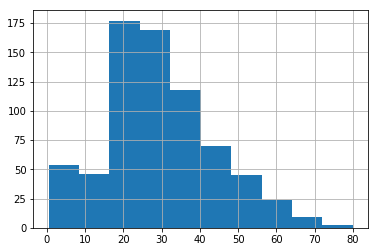

In [54]:
age.hist()

### Exercise

* What is the maximum Fare that was paid? And the median?

In [56]:
# %load solutions/06_solutions.py
df['Fare'].max()


512.3292

In [58]:
# %load solutions/07_solutions.py
df['Fare'].median()


14.4542

* Calculate the average survival ratio for all passengers (note: the 'Survived' column indicates whether someone survived (1) or not (0)).

In [61]:
# %load solutions/08_solutions.py
df['Survived'].sum() / df.shape[0]


0.3838383838383838

In [62]:
# %load solutions/09_solutions.py
df['Survived'].mean()


0.3838383838383838

* Select the sub-dataframe for which the men are older than 60 years old.

In [ ]:
# %load solutions/10_solutions.py
((df['Age'] > 60) & (df['Sex'] == 'male')).value_counts()[True]


* Based on the titanic data set, select all rows for male passengers and calculate the mean age of those passengers. Do the same for the female passengers.

In [66]:
# %load solutions/11_solutions.py
df[df['Sex'] == 'male']['Age'].mean()


30.72664459161148

In [68]:
# %load solutions/12_solutions.py
df[df['Sex'] == 'female']['Age'].mean()


27.915708812260537

* Plot the Fare distribution.

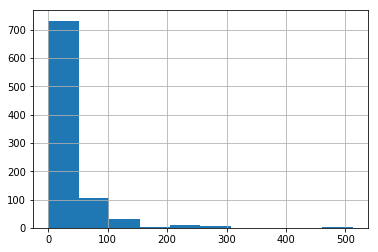

In [70]:
# %load solutions/13_solutions.py
df['Fare'].hist()


## 5. The group-by operation

### Some 'theory': the groupby operation (split-apply-combine)

In [71]:
df = pd.DataFrame({'key':['A','B','C','A','B','C','A','B','C'],
                   'data': [0, 5, 10, 5, 10, 15, 10, 15, 20]})
df

,key,data
0,A,0
1,B,5
2,C,10
3,A,5
...,...,...
5,C,15
6,A,10
7,B,15
8,C,20


### Recap: aggregating functions

When analyzing data, you often calculate summary statistics (aggregations like the mean, max, ...). As we have seen before, we can easily calculate such a statistic for a Series or column using one of the many available methods. For example:

In [72]:
df['data'].sum()

90

However, in many cases your data has certain groups in it, and in that case, you may want to calculate this statistic for each of the groups.

For example, in the above dataframe `df`, there is a column 'key' which has three possible values: 'A', 'B' and 'C'. When we want to calculate the sum for each of those groups, we could do the following:

In [73]:
for key in ['A', 'B', 'C']:
    print(key, df[df['key'] == key]['data'].sum())

A 15
B 30
C 45


This becomes very verbose when having multiple groups. You could make the above a bit easier by looping over the different values, but still, it is not very convenient to work with.

What we did above, applying a function on different groups, is a "groupby operation", and pandas provides some convenient functionality for this.

### Groupby: applying functions per group

The "group by" concept: we want to **apply the same function on subsets of your dataframe, based on some key to split the dataframe in subsets**

This operation is also referred to as the "split-apply-combine" operation, involving the following steps:

* **Splitting** the data into groups based on some criteria
* **Applying** a function to each group independently
* **Combining** the results into a data structure

<img src="./splitApplyCombine.png">

Similar to SQL `GROUP BY`

Instead of doing the manual filtering as above


    df[df['key'] == "A"].sum()
    df[df['key'] == "B"].sum()
    ...

pandas provides the `groupby` method to do exactly this:

In [74]:
df.groupby('key').sum()

,data
key,
A,15
B,30
C,45


In [75]:
df.groupby('key').aggregate(np.sum)  # 'sum'

,data
key,
A,15
B,30
C,45


And many more methods are available. 

In [76]:
df.groupby('key')['data'].sum()

key
A    15
B    30
C    45
Name: data, dtype: int64

### Exercise: Application of the groupby concept on the titanic data

We go back to the titanic passengers survival data:

In [78]:
df = pd.read_csv("datasets/titanic.csv")
df = df.set_index('Name')

In [79]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Name,,,,,,,,,,,
"Braund, Mr. Owen Harris",1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
"Heikkinen, Miss. Laina",3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1,1,female,35.0,1,0,113803,53.1000,C123,S
"Allen, Mr. William Henry",5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


* Using `groupby()`, calculate the average age for each sex.</li>


In [ ]:
# %load solutions/14_solutions.py
df.groupby('Sex')['Age'].mean()


* Using the `groupby()` function, plot the age distribution for each sex.

In [82]:
# %load solutions/15_solutions.py

* Plot the fare distribution based on the class.

In [ ]:
# %load solutions/16_solutions.py

* Plot the survival rate by class with a bar plot.

In [ ]:
# %load solutions/17_solutions.py

* Compute the survival rate grouping by class and sex. (Hint: you can pass a list to the `groupby` function)

In [84]:
# %load solutions/18_solutions.py
df.groupby(['Pclass', 'Sex'])['Survived'].mean().to_frame()


Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

## 6. Using `seaborn` for statistical analysis and plotting

We already used `matplotlib` and `pandas` to plot some information. `seaborn` offers some nice plotting capabilities to make statistical analysis with a minimum of preprocessing.

In [85]:
import seaborn as sns

Check the documentation of `seaborn.catplot` and plot the survival rate grouping by the class and sex.

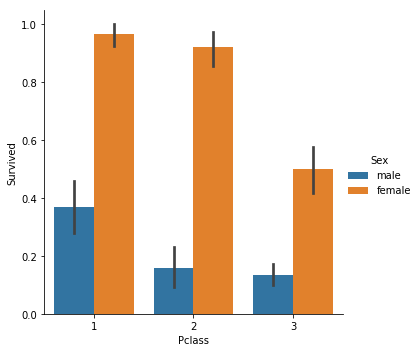

In [87]:
# %load solutions/19_solutions.py
sns.catplot(data=df, x='Pclass', y='Survived', hue='Sex', kind='bar')


Sometime, one is intersted in seeing the distribution differences of some variables. The function `seaborn.boxplot` allows to plot such interaction. You can use this function to plot the `Fare` distribution splitting the data using the `Survived` and `Sex` variable.

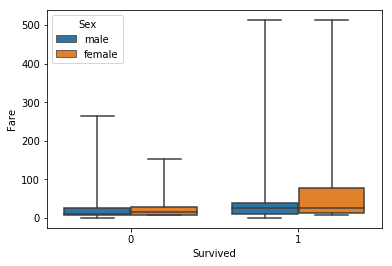

In [89]:
# %load solutions/20_solutions.py
sns.boxplot(data=df, y='Fare', x='Survived', hue='Sex', whis=1000)


The boxplot give information about the different quantiles. One can use the `seaborn.violinplot` to get the distribution information instead of the quantiles. Check the documentation of `seaborn.violinplot` and plot the same information as previously requested.

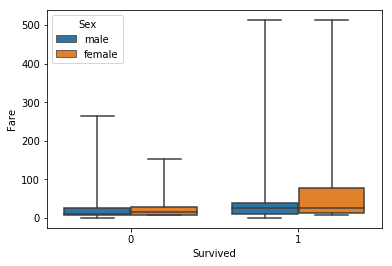

In [91]:
# %load solutions/20_solutions.py
sns.boxplot(data=df, y='Fare', x='Survived', hue='Sex', whis=1000)


Another useful plotting tool is the function `seaborn.paiplot` which plot the interaction between all the different feature.

In [ ]:
sns.pairplot(df, hue='Survived')

However, this plotting method is better suited to visualize interaction for continuous feature and with a limited number of features. Let's check an example with the `iris` dataset.

In [ ]:
import seaborn as sns
sns.set(style="ticks")

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

## 7. Data import and export

A wide range of input/output formats are natively supported by pandas:

* CSV, text
* SQL database
* Excel
* HDF5
* json
* html
* pickle
* sas, stata
* (parquet)
* ...

In [ ]:
# pd.read

In [ ]:
# df.to

Very powerful csv reader:

In [92]:
pd.read_csv?

Luckily, if we have a well formed csv file, we don't need many of those arguments:

In [93]:
df = pd.read_csv("datasets/titanic.csv")

In [94]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div class="alert alert-success">

<b>EXERCISE</b>: Read the `data/20000101_20161231-NO2.csv` file into a DataFrame `no2`
<br><br>
Some aspects about the file:
 <ul>
  <li>Which separator is used in the file?</li>
  <li>The second row includes unit information and should be skipped (check `skiprows` keyword)</li>
  <li>For missing values, it uses the `'n/d'` notation (check `na_values` keyword)</li>
  <li>We want to parse the 'timestamp' column as datetimes (check the `parse_dates` keyword)</li>
</ul>
</div>

In [96]:
# %load solutions/22_solutions.py
no2 = pd.read_csv('datasets/20000101_20161231-NO2.csv', sep=';', skiprows=[1], na_values=['n/d'],
                  index_col=0, parse_dates=True)
no2.head()


,BASCH,BONAP,PA18,VERS
timestamp,,,,
2000-01-01 01:00:00,108.0,NaN,65.0,47.0
2000-01-01 02:00:00,104.0,60.0,77.0,42.0
2000-01-01 03:00:00,97.0,58.0,73.0,34.0
2000-01-01 04:00:00,77.0,52.0,57.0,29.0
2000-01-01 05:00:00,79.0,52.0,64.0,28.0


## 7. Working with time series data

In [97]:
no2 = pd.read_csv('datasets/20000101_20161231-NO2.csv', sep=';',
                  skiprows=[1], na_values=['n/d'],
                  index_col=0, parse_dates=True)

When we ensure the DataFrame has a `DatetimeIndex`, time-series related functionality becomes available:

In [98]:
no2.index

DatetimeIndex(['2000-01-01 01:00:00', '2000-01-01 02:00:00',
               '2000-01-01 03:00:00', '2000-01-01 04:00:00',
               '2000-01-01 05:00:00', '2000-01-01 06:00:00',
               '2000-01-01 07:00:00', '2000-01-01 08:00:00',
               '2000-01-01 09:00:00', '2000-01-01 10:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=149039, freq=None)

Indexing a time series works with strings:

In [99]:
no2["2010-01-01 09:00": "2010-01-01 12:00"]

,BASCH,BONAP,PA18,VERS
timestamp,,,,
2010-01-01 09:00:00,31.0,27.0,28.0,14.0
2010-01-01 10:00:00,41.0,31.0,30.0,14.0
2010-01-01 11:00:00,48.0,32.0,33.0,16.0
2010-01-01 12:00:00,63.0,33.0,39.0,19.0


A nice feature is "partial string" indexing, so you don't need to provide the full datetime string.

E.g. all data of January up to March 2012:

In [100]:
no2['2012-01':'2012-03']

,BASCH,BONAP,PA18,VERS
timestamp,,,,
2012-01-01 00:00:00,44.0,34.0,32.0,7.0
2012-01-01 01:00:00,56.0,35.0,29.0,9.0
2012-01-01 02:00:00,50.0,36.0,29.0,7.0
2012-01-01 03:00:00,46.0,34.0,22.0,8.0
...,...,...,...,...
2012-03-31 20:00:00,61.0,55.0,29.0,17.0
2012-03-31 21:00:00,46.0,49.0,32.0,14.0
2012-03-31 22:00:00,56.0,41.0,27.0,14.0
2012-03-31 23:00:00,59.0,51.0,29.0,13.0


Time and date components can be accessed from the index:

In [101]:
no2.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='timestamp', length=149039)

In [102]:
no2.index.year

Int64Index([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
            ...
            2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016],
           dtype='int64', name='timestamp', length=149039)

## The power of pandas: `resample`

A very powerfull method is **`resample`: converting the frequency of the time series** (e.g. from hourly to daily data).

Remember the air quality data:

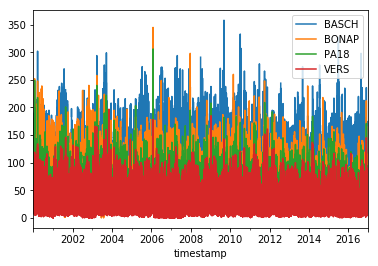

In [103]:
no2.plot()

The time series has a frequency of 1 hour. I want to change this to daily:

In [104]:
no2.head()

,BASCH,BONAP,PA18,VERS
timestamp,,,,
2000-01-01 01:00:00,108.0,NaN,65.0,47.0
2000-01-01 02:00:00,104.0,60.0,77.0,42.0
2000-01-01 03:00:00,97.0,58.0,73.0,34.0
2000-01-01 04:00:00,77.0,52.0,57.0,29.0
2000-01-01 05:00:00,79.0,52.0,64.0,28.0


In [105]:
no2.resample('D').mean().head()

,BASCH,BONAP,PA18,VERS
timestamp,,,,
2000-01-01,83.173913,53.772727,64.695652,36.521739
2000-01-02,78.708333,59.250000,63.708333,17.166667
2000-01-03,82.333333,73.541667,61.000000,23.083333
2000-01-04,78.500000,73.708333,48.863636,23.791667
2000-01-05,94.291667,90.458333,60.166667,28.214286


Above I take the mean, but as with `groupby` I can also specify other methods:

In [ ]:
no2.resample('D').max().head()

The string to specify the new time frequency: http://pandas.pydata.org/pandas-docs/dev/timeseries.html#offset-aliases  
These strings can also be combined with numbers, eg `'10D'`.

Further exploring the data:

In [ ]:
no2.resample('M').mean().plot() # 'A'

In [ ]:
no2.loc['2009':, 'VERS'].resample('M').agg(['mean', 'median']).plot()

### Exercise

The evolution of the yearly averages with, and the overall mean of all stations

* Use `resample` and `plot` to plot the yearly averages for the different stations.
* The overall mean of all stations can be calculated by taking the mean of the different columns (`.mean(axis=1)`).


In [ ]:
# %load solutions/23_solutions.py
no2.resample('A').mean().plot()
no2.mean(axis=1).resample('A').mean().plot(color='k', linestyle='--',
                                           linewidth=4)


## 8. What I didn't talk about

- Concatenating data: `pd.concat`
- Merging and joining data: `pd.merge`
- Reshaping data: `pivot_table`, `melt`, `stack`, `unstack`
- Working with missing data: `isnull`, `dropna`, `interpolate`, ...
- ...


## Further reading

* Pandas documentation: http://pandas.pydata.org/pandas-docs/stable/

* Books

    * "Python for Data Analysis" by Wes McKinney
    * "Python Data Science Handbook" by Jake VanderPlas

* Tutorials (many good online tutorials!)

  * https://github.com/jorisvandenbossche/pandas-tutorial
  * https://github.com/brandon-rhodes/pycon-pandas-tutorial

* Tom Augspurger's blog

  * https://tomaugspurger.github.io/modern-1.html